## Experiment Notebook

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, random_split
import torch.nn.init as init
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Train student from scratch without Teacher



### Load data

In [6]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224, 224)),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [7]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataset_val = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Hyperparameters
batch_size = 128
learning_rate = 0.1


In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
train_loader_val = DataLoader(train_dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Load ResNet18 Student model

In [11]:
student = models.resnet18()

In [12]:
student.fc = nn.Linear(student.fc.in_features, 10)
student = student.to(device)

In [13]:
for param in student.parameters():
    param.requires_grad = True

### Train Student without teacher

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [ ]:
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    student.train()

    # Train
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()



In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/resnet18_student_non_learning.pth")

## Train student with Teacher

In [30]:
# Hyperparameters
learning_rate = 0.1
batch_size = 128
T = 3
soft_target_loss_weight = 0.6

In [ ]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# transform_train_student = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])

transform_teacher = transforms.Compose([
        transforms.Resize(224),
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataset_val = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_val = DataLoader(train_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
student = models.resnet18()
student.fc = nn.Linear(student.fc.in_features, 10)
student = student.to(device)
for param in student.parameters():
    param.requires_grad = True

In [ ]:
teacher = models.resnet50()
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
teacher.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/teacher_finetuned_cifar10_v2.pth'))
teacher = teacher.to(device)

In [31]:
criterion = nn.CrossEntropyLoss()
criterion_kd = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [32]:
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      # soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
      # soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

      # soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)
      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      loss = soft_target_loss_weight * soft_targets_loss + (1 - soft_target_loss_weight) * label_loss
      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

[1] train_loss: 1.644, train_accuracy: 39.55 %
[1] test_loss: 1.640, test_accuracy: 39.20 %
[2] train_loss: 1.372, train_accuracy: 50.73 %
[2] test_loss: 1.383, test_accuracy: 50.57 %
[3] train_loss: 1.407, train_accuracy: 52.31 %
[3] test_loss: 1.430, test_accuracy: 52.20 %
[4] train_loss: 1.470, train_accuracy: 52.70 %
[4] test_loss: 1.508, test_accuracy: 51.78 %
[5] train_loss: 1.071, train_accuracy: 63.07 %
[5] test_loss: 1.128, test_accuracy: 62.51 %
[6] train_loss: 1.128, train_accuracy: 62.55 %
[6] test_loss: 1.177, test_accuracy: 61.36 %
[7] train_loss: 1.159, train_accuracy: 63.76 %
[7] test_loss: 1.223, test_accuracy: 62.90 %
[8] train_loss: 0.774, train_accuracy: 73.25 %
[8] test_loss: 0.856, test_accuracy: 71.46 %
[9] train_loss: 0.818, train_accuracy: 73.34 %
[9] test_loss: 0.891, test_accuracy: 71.44 %
[10] train_loss: 0.795, train_accuracy: 73.51 %
[10] test_loss: 0.881, test_accuracy: 71.66 %
[11] train_loss: 0.748, train_accuracy: 75.55 %
[11] test_loss: 0.840, test_ac

In [33]:
torch.save(student.state_dict(), "resnet18_student_models/resnet18_student_learning.pth")

In [34]:
student.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
print(test_loss)

[1.6397755583630333, 1.3833925603311272, 1.4297452516193632, 1.508203906348989, 1.1279136764852307, 1.1769341901887822, 1.2230747538276865, 0.8558801442761964, 0.8905799403975282, 0.8806624088106276, 0.8395337092725537, 0.9674467678311505, 1.0826236085046697, 0.8658474668671813, 0.7662289180333102, 0.7466863118395021, 0.6878365244292006, 0.7120498614975169, 0.7105912551095214, 0.7362786506927466, 0.6735697652720198, 0.5949664549737037, 0.6325208778622784, 0.6067945545987238, 0.6004548257664789, 0.6859264807610572, 0.6470658407558368, 0.598163435730753, 0.5740395403361018, 0.5637047713315939, 0.556413800656041, 0.5566590756555146, 0.5580172146422954, 0.5800844083858442, 0.5669415793086909, 0.556044409546671, 0.5445413427262367, 0.5432408057813403, 0.5477433521536332, 0.5480058068716074, 0.5800431110436404, 0.5637164132881768, 0.5462190554111819, 0.5566474484114707, 0.5592173368115968, 0.5499795028303243, 0.5633000501349003, 0.5651015190384056, 0.5627339787875549, 0.5534051532232309]


In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/resnet18_student_learning.pth")

In [ ]:
# archive - previous run with T=2 and soft target loss weight = 0.3
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      # soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
      # soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

      # soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)
      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      loss = soft_target_loss_weight * soft_targets_loss + (1 - soft_target_loss_weight) * label_loss
      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

## Intermediate layer transfer

In [14]:
class Hook():
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
        print(f"Hook Set: {layer}")
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [15]:
class ConvolutionalRegressor2(nn.Module):
    def __init__(self, in_channels=1024, out_channels=128, kernel_size=4, stride=2, padding=1):
        super(ConvolutionalRegressor2, self).__init__()
        self.regressor = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.init_weights()

    def init_weights(self):
        init.kaiming_uniform_(self.regressor[0].weight, mode='fan_in', nonlinearity='relu')
        if self.regressor[0].bias is not None:
            init.constant_(self.regressor[0].bias, 0)

    def forward(self, x):
        return self.regressor(x)

In [17]:
# Hyperparameters
learning_rate = 0.1
batch_size = 128
T = 3
soft_target_loss_weight = 0.3
intermediate_loss_weight = 0.6
ce_loss_weight = 1 - soft_target_loss_weight - intermediate_loss_weight

In [18]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

transform_teacher = transforms.Compose([
        transforms.Resize(224),
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [19]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataset_val = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_val = DataLoader(train_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
teacher = models.resnet50()
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
#teacher.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/teacher_finetuned_cifar10_v2.pth'))
teacher.load_state_dict(torch.load('trained_model/teacher_finetuned_cifar10_v2.pth'))
teacher = teacher.to(device)

In [24]:
student = models.resnet18()
student.fc = nn.Linear(student.fc.in_features, 10)
student = student.to(device)
for param in student.parameters():
    param.requires_grad = True

In [25]:
criterion = nn.CrossEntropyLoss()
criterion_kd = nn.KLDivLoss(reduction='batchmean')
criterion_mse = nn.MSELoss()
regressor1 = ConvolutionalRegressor2(64, 64, 4, 7).to(device)
regressor2 = ConvolutionalRegressor2(128, 128, 7, 7).to(device)
regressor3 = ConvolutionalRegressor2(256, 256, 7, 7).to(device)
regressor4 = ConvolutionalRegressor2(512, 512, 7, 7).to(device)
optimizer = optim.SGD(list(filter(lambda p: p.requires_grad, student.parameters())) + \
                      list(regressor1.parameters()) + list(regressor2.parameters()) + list(regressor3.parameters()) + list(regressor4.parameters()),
                      lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

In [26]:
teacher_layer1 = teacher.layer1[-1].conv1
teacher_layer1_hook = Hook(teacher_layer1)
student_layer1 = student.layer1[-1].conv1
student_layer1_hook = Hook(student_layer1)

teacher_layer2 = teacher.layer2[-1].conv1
teacher_layer2_hook = Hook(teacher_layer2)
student_layer2 = student.layer2[-1].conv1
student_layer2_hook = Hook(student_layer2)

teacher_layer3 = teacher.layer3[-1].conv1
teacher_layer3_hook = Hook(teacher_layer3)
student_layer3 = student.layer3[-1].conv1
student_layer3_hook = Hook(student_layer3)

teacher_layer4 = teacher.layer4[-1].conv1
teacher_layer4_hook = Hook(teacher_layer4)
student_layer4 = student.layer4[-1].conv1
student_layer4_hook = Hook(student_layer4)

Hook Set: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Hook Set: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Hook Set: Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Hook Set: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Hook Set: Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Hook Set: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Hook Set: Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
Hook Set: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [ ]:
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()
    regressor1.train()
    regressor2.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      teacher_activations1 = teacher_layer1_hook.output
      student_activations1 = student_layer1_hook.output
      teacher_activations1_trans = regressor1.forward(teacher_activations1)
      mse_loss1 = criterion_mse(student_activations1, teacher_activations1_trans)

      teacher_activations2 = teacher_layer2_hook.output
      student_activations2 = student_layer2_hook.output
      teacher_activations2_trans = regressor2.forward(teacher_activations2)
      mse_loss2 = criterion_mse(student_activations2, teacher_activations2_trans)

      teacher_activations3 = teacher_layer3_hook.output
      student_activations3 = student_layer3_hook.output
      teacher_activations3_trans = regressor3.forward(teacher_activations3)
      mse_loss3 = criterion_mse(student_activations3, teacher_activations3_trans)

      teacher_activations4 = teacher_layer4_hook.output
      student_activations4 = student_layer4_hook.output
      teacher_activations4_trans = regressor4.forward(teacher_activations4)
      mse_loss4 = criterion_mse(student_activations4, teacher_activations4_trans)

      loss = soft_target_loss_weight * soft_targets_loss + \
      ce_loss_weight * label_loss + \
      intermediate_loss_weight * (mse_loss1 + mse_loss2 + mse_loss3 + mse_loss4)/4

      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    regressor1.eval()
    regressor2.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

student_layer1_hook.close()
teacher_layer1_hook.close()
student_layer2_hook.close()
teacher_layer2_hook.close()

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/resnet18_student_learning_intermediate.pth")

#### Split Transfer on Resnet18

In [27]:
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()
#First Stage
#Train second layer
student_layer2.requires_grad = False
for epoch in range(num_epochs):
    student.train()
    regressor1.train()
    regressor2.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      #soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               #torch.softmax(teacher_logits / T, dim=1))
      #label_loss = criterion(student_logits, labels)

      teacher_activations1 = teacher_layer1_hook.output
      student_activations1 = student_layer1_hook.output
      teacher_activations1_trans = regressor1.forward(teacher_activations1)
      mse_loss1 = criterion_mse(student_activations1, teacher_activations1_trans)

      teacher_activations2 = teacher_layer2_hook.output
      student_activations2 = student_layer2_hook.output
      teacher_activations2_trans = regressor2.forward(teacher_activations2)
      mse_loss2 = criterion_mse(student_activations2, teacher_activations2_trans)

      #teacher_activations3 = teacher_layer3_hook.output
      #student_activations3 = student_layer3_hook.output
      #teacher_activations3_trans = regressor3.forward(teacher_activations3)
      #mse_loss3 = criterion_mse(student_activations3, teacher_activations3_trans)

      #teacher_activations4 = teacher_layer4_hook.output
      #student_activations4 = student_layer4_hook.output
      #teacher_activations4_trans = regressor4.forward(teacher_activations4)
      #mse_loss4 = criterion_mse(student_activations4, teacher_activations4_trans)

      loss = (mse_loss1 + mse_loss2) / 2

      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    regressor1.eval()
    regressor2.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

for param in student.parameters():
        param.requires_grad = True
student_layer1_hook.close()
teacher_layer1_hook.close()
student_layer2_hook.close()
teacher_layer2_hook.close()

/home/hmrush/miniconda3/envs/mlenv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[1] train_loss: 2.592, train_accuracy: 9.58 %
[1] test_loss: 2.596, test_accuracy: 9.82 %
[2] train_loss: 2.573, train_accuracy: 9.11 %
[2] test_loss: 2.572, test_accuracy: 8.94 %
[3] train_loss: 2.578, train_accuracy: 9.00 %
[3] test_loss: 2.575, test_accuracy: 9.16 %
[4] train_loss: 2.618, train_accuracy: 9.44 %
[4] test_loss: 2.627, test_accuracy: 9.14 %
[5] train_loss: 2.637, train_accuracy: 9.38 %
[5] test_loss: 2.633, test_accuracy: 9.37 %
[6] train_loss: 2.640, train_accuracy: 9.96 %
[6] test_loss: 2.637, test_accuracy: 9.74 %
[7] train_loss: 2.639, train_accuracy: 9.75 %
[7] test_loss: 2.630, test_accuracy: 9.77 %
[8] train_loss: 2.645, train_accuracy: 9.89 %
[8] test_loss: 2.638, test_accuracy: 9.96 %
[9] train_loss: 2.651, train_accuracy: 9.53 %
[9] test_loss: 2.645, test_accuracy: 9.58 %
[10] train_loss: 2.680, train_accuracy: 9.53 %
[10] test_loss: 2.674, test_accuracy: 9.35 %
[11] train_loss: 2.644, train_accuracy: 9.35 %
[11] test_loss: 2.643, test_accuracy: 9.36 %
[12] t

In [29]:
torch.save(student.state_dict(), "resnet18_student_models/resnet18_student_learning_first_stage.pth")

In [ ]:
# archive - match 4 layers but intermediate loss weight = 0.3
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()
    regressor1.train()
    regressor2.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      teacher_activations1 = teacher_layer1_hook.output
      student_activations1 = student_layer1_hook.output
      teacher_activations1_trans = regressor1.forward(teacher_activations1)
      mse_loss1 = criterion_mse(student_activations1, teacher_activations1_trans)

      teacher_activations2 = teacher_layer2_hook.output
      student_activations2 = student_layer2_hook.output
      teacher_activations2_trans = regressor2.forward(teacher_activations2)
      mse_loss2 = criterion_mse(student_activations2, teacher_activations2_trans)

      teacher_activations3 = teacher_layer3_hook.output
      student_activations3 = student_layer3_hook.output
      teacher_activations3_trans = regressor3.forward(teacher_activations3)
      mse_loss3 = criterion_mse(student_activations3, teacher_activations3_trans)

      teacher_activations4 = teacher_layer4_hook.output
      student_activations4 = student_layer4_hook.output
      teacher_activations4_trans = regressor4.forward(teacher_activations4)
      mse_loss4 = criterion_mse(student_activations4, teacher_activations4_trans)

      loss = soft_target_loss_weight * soft_targets_loss + \
      ce_loss_weight * label_loss + \
      intermediate_loss_weight * (mse_loss1 + mse_loss2 + mse_loss3 + mse_loss4)/4

      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    regressor1.eval()
    regressor2.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

student_layer1_hook.close()
teacher_layer1_hook.close()
student_layer2_hook.close()
teacher_layer2_hook.close()

In [ ]:
# archive - matching 2 layers only
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()
    regressor1.train()
    regressor2.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      teacher_activations1 = teacher_layer1_hook.output
      student_activations1 = student_layer1_hook.output
      teacher_activations1_trans = regressor1.forward(teacher_activations1)
      mse_loss1 = criterion_mse(student_activations1, teacher_activations1_trans)
      teacher_activations2 = teacher_layer2_hook.output
      student_activations2 = student_layer2_hook.output
      teacher_activations2_trans = regressor2.forward(teacher_activations2)
      mse_loss2 = criterion_mse(student_activations2, teacher_activations2_trans)

      loss = soft_target_loss_weight * soft_targets_loss + \
      ce_loss_weight * label_loss + \
      intermediate_loss_weight * (mse_loss1 + mse_loss2)/2

      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    regressor1.eval()
    regressor2.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

student_layer1_hook.close()
teacher_layer1_hook.close()
student_layer2_hook.close()
teacher_layer2_hook.close()

## Plot normalized loss

In [36]:
non_learning_student = [
    1.621,
    1.338,
    1.336,
    1.056,
    0.973,
    1.062,
    0.982,
    0.797,
    0.772,
    0.790,
    0.728,
    0.793,
    0.727,
    0.745,
    0.617,
    0.602,
    0.611,
    0.587,
    0.592,
    0.591,
    0.658,
    0.504,
    0.515,
    0.548,
    0.533,
    0.547,
    0.558,
    0.524,
    0.483,
    0.498,
    0.490,
    0.499,
    0.498,
    0.510,
    0.509,
    0.476,
    0.504,
    0.485,
    0.493,
    0.479,
    0.495,
    0.505,
    0.492,
    0.491,
    0.497,
    0.505,
    0.503,
    0.508,
    0.508,
    0.504,
]
learning_student = [
    1.406,
    1.378,
    1.155,
    0.982,
    0.952,
    0.919,
    0.830,
    0.762,
    0.781,
    0.728,
    0.773,
    0.756,
    0.832,
    0.717,
    0.609,
    0.652,
    0.615,
    0.604,
    0.631,
    0.647,
    0.653,
    0.548,
    0.564,
    0.569,
    0.578,
    0.564,
    0.561,
    0.569,
    0.508,
    0.506,
    0.510,
    0.519,
    0.502,
    0.514,
    0.509,
    0.491,
    0.501,
    0.504,
    0.497,
    0.510,
    0.495,
    0.505,
    0.490,
    0.496,
    0.492,
    0.496,
    0.495,
    0.492,
    0.505,
    0.492,
]
intermediate_student = [
    1.626,
    1.305,
    1.163,
    1.241,
    1.206,
    1.173,
    0.986,
    1.100,
    0.813,
    0.935,
    0.889,
    0.877,
    0.851,
    0.945,
    0.901,
    0.791,
    0.708,
    0.698,
    0.689,
    0.649,
    0.666,
    0.712,
    0.704,
    0.732,
    0.574,
    0.608,
    0.537,
    0.547,
    0.582,
    0.575,
    0.569,
    0.594,
    0.517,
    0.541,
    0.516,
    0.524,
    0.530,
    0.519,
    0.517,
    0.530,
    0.500,
    0.500,
    0.496,
    0.501,
    0.501,
    0.499,
    0.508,
    0.509,
    0.488,
    0.496,
]
split_training_res = [
1.640,
1.383,
1.430,
1.508,
1.128,
1.177,
1.223,
0.856,
0.891,
0.881,
0.840,
0.967,
1.083,
0.866,
0.766,
0.747,
0.688,
0.712,
0.711,
0.736,
0.674,
0.595,
0.633,
0.607,
0.600,
0.686,
0.647,
0.598,
0.574,
0.564,
0.556,
0.557,
0.558,
0.580,
0.567,
0.556,
0.545,
0.543,
0.548,
0.548,
0.580,
0.564,
0.546,
0.557,
0.559,
0.550,
0.563,
0.565,
0.563,
0.553

]

In [37]:
norm_non_learning_student = (non_learning_student-np.min(non_learning_student))/(np.max(non_learning_student)-np.min(non_learning_student)) 
norm_learning_student = (learning_student-np.min(learning_student))/(np.max(learning_student)-np.min(learning_student)) 
norm_intermediate_student = (intermediate_student-np.min(intermediate_student))/(np.max(intermediate_student)-np.min(intermediate_student)) 
norm_split_training = (split_training_res-np.min(split_training_res))/(np.max(split_training_res)-np.min(split_training_res))

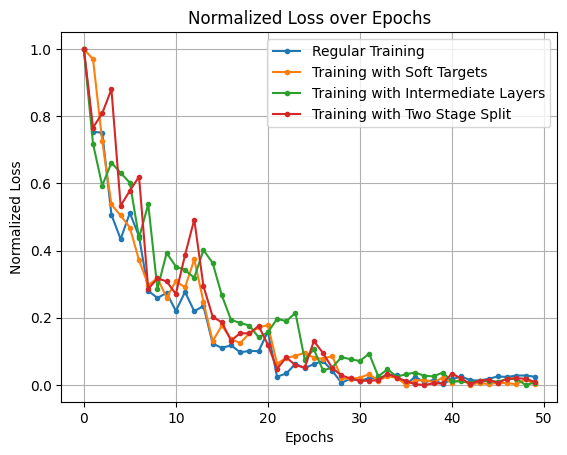

In [38]:
plt.plot(norm_non_learning_student, marker='o', markersize=3, label = 'Regular Training')
plt.plot(norm_learning_student, marker='o', markersize=3, label = 'Training with Soft Targets')
plt.plot(norm_intermediate_student, marker='o', markersize=3, label = 'Training with Intermediate Layers')
plt.plot(norm_split_training, marker='o', markersize=3, label = 'Training with Two Stage Split')
plt.title('Normalized Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Normalized Loss')
plt.legend()
plt.grid()